# FRA 503: Deep Reinforcement Learning Cart Pole [ HW2 ]

## 65340500062 Aitthikit Kitcharoennon

## Learning Objectives:

- Understand how a reinforcement learning agent learns (i.e., evaluates and improves its policy) in an environment where the true dynamic model is unknown.

- Gain insight into different reinforcement learning algorithms, including Monte Carlo methods, the SARSA algorithm, Q-learning, and Double Q-learning. Analyze their strengths and weaknesses.

- Explore approaches to implementing reinforcement learning in real-world scenarios where the state and action spaces are continuous.



## Part 1: Setting up Cart-Pole Agent.
- For the first part of this homework, you will implement a Cart-Pole agent from scratch, i.e., you must implement the constructor and core functions of the RL Base Class, as well as the algorithms in the Algorithm folder. The core components should include, but are not limited to:

### RL Base class

#### Reward config

Reward setup for the Stabilize Cart-Pole we care 3 Terms of reward
- alive -> agents will get reward when still alive from each step
- terminating -> agents will get penalty when got terminate(From cart out of bound(-3 to 3 m) or pole out of bound(-24 to 24 deg))
- joint_pos -> agents will get penalty when pole position far away from target

In [ ]:
@configclass
class RewardsCfg:
    """Reward terms for the MDP."""

    # (1) Constant running reward
    alive = RewTerm(func=mdp.is_alive, weight=1.0)
    # (2) Failure penalty
    terminating = RewTerm(func=mdp.is_terminated, weight=-2.0)
    # (3) Joint_pos
    joint_pos = RewTerm(func=mdp.joint_pos_target_l2,weight = -1.0 ,params={"asset_cfg": SceneEntityCfg("robot",joint_names = ["cart_to_pole"]),"target" : 0.0})

#### Constructor



Control type: Enumeration of RL algorithms used for decision-making (i.e. Monte Carlo, Temporal Difference, Q-learning, or Double Q-learning).

Number of actions: The total number of discrete actions available to the agent.

Action range: The minimum and maximum values defining the range of possible actions.

Discretize state weight: Weighting factor applied when discretizing the state space for learning.

Learning rate: Determines how quickly the model updates based on new information.

Initial epsilon: The starting probability of taking a random action in an ε-greedy policy.

Epsilon decay rate: The rate at which epsilon decreases over time to favor exploitation over exploration.

Final epsilon: The lowest value epsilon can reach, ensuring some level of exploration remains.

Discount factor: A coefficient (γ) that determines the importance of future rewards in decision-making.


In [ ]:
num_of_action = 11 # Use 11 actions to make agent can handle middle state
action_range = [-12.0, 12.0]  # [min, max]
discretize_state_weight = [5,11,3,3]  # [pose_cart:int, pose_pole:int, vel_cart:int, vel_pole:int]
learning_rate = 0.3
n_episodes = 5000 # 
start_epsilon = 1.0
epsilon_decay = 0.999 # reduce the exploration over time
final_epsilon = 0.01
discount = 0.50

In [ ]:
self.pose_cart_bins = np.linspace(-3.0, 3.0, self.discretize_state_weight[0])  # Range for cart position
self.pose_pole_bins = np.linspace(-0.5, 0.5, self.discretize_state_weight[1])  # Range for pole angle
self.vel_cart_bins = np.linspace(-10.0, 10.0, self.discretize_state_weight[2])  # Range for cart velocity
self.vel_pole_bins = np.linspace(-10.0, 10.0, self.discretize_state_weight[3])  # Range for pole velocity

Values of each parameter from my assumption

num_of_action 11: We need to set it to an odd number because when discrete, they will have 0 (no action) in the action it makes when the cartpole is in a stable state; the agent will select this action to do nothing.

action_range -12 to 12: Got this values from test run and observe it from low action range(-3 to 3) untill find the values that enough to stabilize (-12 to 12) cartpole from critical state (pole position near to terminate point).

discretize_state_weight [5,11,3,3] : We need to set it to an odd number to suitable for setting an odd number of action
- Spilt Cart position to 5 state in -3 to 3 m because it effect to terminate but not often.5 state is enough to make agent know own position.
- Spilt Pole position to 11 state in -0.5 to 0.5 rad because it effect to main task and this is the most often cause to terminate.it should have more state than other state to make agent know pole position more precisely and this is why i will set it to highest state weight.
- Spilt Cart velocity to 3 state in -10 to 10 m/s because it not effect direcly to terminate but at least we should make agent know is cart move to left or right or not moving position.
- Spilt Pole velocity to 3 state in -10 to 10 m/s same as cart position.

learning_rate 0.3 : Use a moderate value balances learning speed and stability.May be tune and test in evaluation.

n_episodes 5000 : From episodes to make agent visit all state and action combination if assume 1 episode agent meet 1 state and action (num of action * state weight = 11*5*11*3*3 = 5445) but in reality 1 episode agent can meet more than 1 state and action that mean we can decrease it if we need.

start_epsilon 1.0 : Set it to one helps the agent sample diverse state-action pairs before committing to a policy.

epsilon_decay 0.999 : From the episode i want to make it decay epsilon to 0.01 when near the 5000 episode.(0.01 = x^5000 | x = 0.999097)

final_epsilon 0.01 : Ensures that even late in training, some exploration still occurs.

discount 0.50 : Use a moderate value because it have suitable value for each algorithm.May be tune and test in evaluation.

#### Core Functions

##### get_discretize_action()

In [ ]:
def get_discretize_action(self, obs_dis) -> int:
    """
    Select an action using an epsilon-greedy policy.

    Args:
        obs_dis (tuple): Discretized observation.

    Returns:
        int: Chosen discrete action index.
    """
    # ========= put your code here =========#
    if self.control_type == ControlType.DOUBLE_Q_LEARNING:
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.num_of_action)
        return int(np.argmax(self.qa_values[obs_dis] + self.qb_values[obs_dis]))
    else:
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.num_of_action)
        return int(np.argmax(self.q_values[obs_dis]))
    # ======================================#

In this function we set it to 2 conditon because in Double_Q_learning are use qa and qb to select best actions.

Use random to select action depend on epsilon.To exploration.

##### mapping_action()

In [ ]:
def mapping_action(self, action):
    """
    Maps a discrete action in range [0, n] to a continuous value in [action_min, action_max].

    Args:
        action (int): Discrete action in range [0, n]
        n (int): Number of discrete actions
    
    Returns:
        torch.Tensor: Scaled action tensor.
    """
    # ========= put your code here =========#
    action_min, action_max = self.action_range
    return torch.tensor(action_min + (action_max - action_min) * (action / (self.num_of_action - 1)), dtype=torch.float32)
    # ======================================#

##### discretize_state()

In [ ]:
def discretize_state(self, obs: dict):
    """
    Discretize the observation state.

    Args:
        obs (dict): Observation dictionary containing policy states.

    Returns:
        Tuple[pose_cart:int, pose_pole:int, vel_cart:int, vel_pole:int]: Discretized state.
    """

    # ========= put your code here =========#
    state = obs['policy'].cpu().numpy().flatten()

    pose_cart = np.digitize(state[0], self.pose_cart_bins) # Subtract 1 for zero-indexed bins
    pose_pole = np.digitize(state[1], self.pose_pole_bins)
    vel_cart = np.digitize(state[2], self.vel_cart_bins)
    vel_pole = np.digitize(state[3], self.vel_pole_bins)
    return (pose_cart, pose_pole, vel_cart, vel_pole)
    # ======================================#

In [ ]:
self.pose_cart_bins = np.linspace(-3.0, 3.0, self.discretize_state_weight[0])  # Range for cart position
self.pose_pole_bins = np.linspace(-0.5, 0.5, self.discretize_state_weight[1])  # Range for pole angle
self.vel_cart_bins = np.linspace(-10.0, 10.0, self.discretize_state_weight[2])  # Range for cart velocity
self.vel_pole_bins = np.linspace(-10.0, 10.0, self.discretize_state_weight[3])  # Range for pole velocity

##### decay_epsilon()

In [ ]:
def decay_epsilon(self):
    """
    Decay epsilon value to reduce exploration over time.
    """
    self.epsilon = max(self.final_epsilon, self.epsilon * self.epsilon_decay)

Use exponential epsilon decay Faster drop in the beginning, then slows down. Ensures a smooth transition from exploration to exploitation.

### Algorithm class

#### Monte Carlo class

In [ ]:
def update(self):
    """
    Update Q-values using Monte Carlo.

    This method applies the Monte Carlo update rule to improve policy decisions by updating the Q-table.
    """
    G = 0  # Initialize return
    for t in reversed(range(len(self.reward_hist))):  # Process episode in reverse
        state = self.obs_hist[t]
        action = self.action_hist[t]
        reward = self.reward_hist[t]

        G = self.discount_factor * G + reward  # Compute return
        
        # First-visit MC: Only update if it's the first occurrence in the episode
        if (state, action) not in zip(self.obs_hist[:t], self.action_hist[:t]):
            self.n_values[state][action] += 1  # Increment visit count
            alpha = 1 / self.n_values[state][action]  # Learning rate = 1 / visit count
            # Update Q-value
            self.q_values[state][action] += alpha * (G - self.q_values[state][action])

    # Clear episode history after update
    self.obs_hist.clear()
    self.action_hist.clear()
    self.reward_hist.clear()

#### SARSA class

In [ ]:
def update(self,state, action, reward, next_state, next_action):
    """
    Update Q-values using SARSA .

    This method applies the SARSA update rule to improve policy decisions by updating the Q-table.
    """
    target = reward + self.discount_factor * self.q_values[next_state][next_action]
    self.q_values[state][action] += self.lr * (target - self.q_values[state][action])

#### Q-Learning Class

In [ ]:
def update(self,state,action,reward,next_state):
        """
        Update Q-values using Q-Learning.

        This method applies the Q-Learning update rule to improve policy decisions by updating the Q-table.
        """
        # Get the best action for the next state
        best_next_action = np.argmax(self.q_values[next_state])
        # Q-Learning update rule
        target = reward + self.discount_factor * self.q_values[next_state][best_next_action]
        self.q_values[state][action] += self.lr * (target - self.q_values[state][action])

#### Double Q-Learning Class

In [ ]:
def update(self,state, action, reward, next_state):
    """
    Update Q-values using Double Q-Learning.

    This method applies the Double Q-Learning update rule to improve policy decisions by updating the Q-table.
    """
    if np.random.rand() < 0.5:
        # Use Q1 to select the best next action
        best_next_action = np.argmax(self.qa_values[next_state])
        # Use Q2 to evaluate the action
        target = reward + self.discount_factor * self.qb_values[next_state][best_next_action]
        self.qa_values[state][action] += self.lr * (target - self.qa_values[state][action])
    else:
        # Use Q2 to select the best next action
        best_next_action = np.argmax(self.qb_values[next_state])
        # Use Q1 to evaluate the action
        target = reward + self.discount_factor * self.qa_values[next_state][best_next_action]
        self.qb_values[state][action] += self.lr * (target - self.qb_values[state][action])
    self.q_values[state][action] = self.qb_values[state][action] + self.qa_values[state][action]
    #======================================#

## Part 2: Trainning & Playing to stabilize Cart-Pole Agent.
You need to implement the training loop in train script and main() in the play script (in the "Can be modified" area of both files). Additionally, you must collect data, analyze results, and save models for evaluating agent performance.

### Training the Agent

Training loop for Q and Double Q Learning algorithm

In [ ]:
obs, _ = env.reset()
timestep = 0
sum_reward = 0
sum_count = 0
wandb.init(project="DRLHW1",name=Algorithm_name)
# simulate environment
while simulation_app.is_running():
    # run everything in inference mode
    with torch.inference_mode():
    
        for episode in tqdm(range(n_episodes)):
            obs, _ = env.reset()
            done = False
            cumulative_reward = 0
            count = 0
            while not done:
                # agent stepping
                action, action_idx = agent.get_action(obs)
                # env stepping
                next_obs, reward, terminated, truncated, _ = env.step(action)
                reward_value = reward.item()
                terminated_value = terminated.item() 
                cumulative_reward += reward_value
                agent.update(agent.discretize_state(obs),action_idx,reward,agent.discretize_state(next_obs)
                    #== put your code here ==#
                )
                done = terminated or truncated
                obs = next_obs
                count += 1
            wandb.log({
                "reward":cumulative_reward,
                "Epsilon":agent.epsilon,
                "Alive_Count":count
            })
            sum_reward += cumulative_reward
            sum_count += count
            if episode % 100 == 0:
                print("avg_score: ", sum_reward / 100.0)
                wandb.log({
                "Sum_reward":sum_reward/100,
                "Sum_Alivecount":sum_count/100,
                })
                sum_reward = 0
                sum_count = 0
                print(agent.epsilon)
                
                # Save Q-Learning agent
                q_value_file = f"{Algorithm_name}_{episode}_{num_of_action}_{action_range[1]}_{discretize_state_weight[0]}_{discretize_state_weight[1]}.json"
                full_path = os.path.join(f"q_value/{task_name}", Algorithm_name)
                # agent.save_model(full_path, q_value_file)
                agent.save_q_value(full_path, q_value_file)
            agent.decay_epsilon()

Training loop for Monte Carlo

In [ ]:
obs, _ = env.reset()
timestep = 0
sum_reward = 0
sum_count = 0
wandb.init(project="DRLHW1",name=Algorithm_name)
# simulate environment
while simulation_app.is_running():
    # run everything in inference mode
    with torch.inference_mode():
    
        for episode in tqdm(range(n_episodes)):
            obs, _ = env.reset()
            done = False
            cumulative_reward = 0
            count = 0
            while not done:
                # agent stepping
                action, action_idx = agent.get_action(obs)
                # env stepping
                next_obs, reward, terminated, truncated, _ = env.step(action)
                next_action, next_action_idx = agent.get_action(next_obs)
                reward_value = reward.item()
                terminated_value = terminated.item() 
                cumulative_reward += reward_value
                agent.obs_hist.append(agent.discretize_state(obs))
                agent.action_hist.append(action_idx)  
                agent.reward_hist.append(reward.item())
                done = terminated or truncated
                obs = next_obs
                count += 1
            agent.update()
            wandb.log({
                "reward":cumulative_reward,
                "Epsilon":agent.epsilon,
                "Alive_Count":count
            })
            sum_reward += cumulative_reward
            sum_count += count
            if episode % 100 == 0:
                print("avg_score: ", sum_reward / 100.0)
                wandb.log({
                "Sum_reward":sum_reward/100,
                "Sum_Alivecount":sum_count/100,
                })
                sum_reward = 0
                sum_count = 0
                print(agent.epsilon)
                
                # Save Q-Learning agent
                q_value_file = f"{Algorithm_name}_{episode}_{num_of_action}_{action_range[1]}_{discretize_state_weight[0]}_{discretize_state_weight[1]}.json"
                full_path = os.path.join(f"q_value/{task_name}", Algorithm_name)
                # agent.save_model(full_path, q_value_file)
                agent.save_q_value(full_path, q_value_file)

            agent.decay_epsilon()

Training loop for SARSA

In [ ]:
obs, _ = env.reset()
timestep = 0
sum_reward = 0
sum_count = 0
wandb.init(project="DRLHW1",name=Algorithm_name)
# simulate environment
while simulation_app.is_running():
    # run everything in inference mode
    with torch.inference_mode():
    
        for episode in tqdm(range(n_episodes)):
            obs, _ = env.reset()
            done = False
            cumulative_reward = 0
            count = 0
            while not done:
                # agent stepping
                action, action_idx = agent.get_action(obs)
                # env stepping
                next_obs, reward, terminated, truncated, _ = env.step(action)
                next_action, next_action_idx = agent.get_action(next_obs)
                reward_value = reward.item()
                terminated_value = terminated.item() 
                cumulative_reward += reward_value

                agent.update(agent.discretize_state(obs),action_idx,reward,agent.discretize_state(next_obs),next_action_idx)
                done = terminated or truncated
                obs = next_obs
                count += 1
            wandb.log({
                "reward":cumulative_reward,
                "Epsilon":agent.epsilon,
                "Alive_Count":count
            })
            sum_reward += cumulative_reward
            sum_count += count
            if episode % 100 == 0:
                print("avg_score: ", sum_reward / 100.0)
                wandb.log({
                "Sum_reward":sum_reward/100,
                "Sum_Alivecount":sum_count/100,
                })
                sum_reward = 0
                sum_count = 0
                print(agent.epsilon)
                
                # Save Q-Learning agent
                q_value_file = f"{Algorithm_name}_{episode}_{num_of_action}_{action_range[1]}_{discretize_state_weight[0]}_{discretize_state_weight[1]}.json"
                full_path = os.path.join(f"q_value/{task_name}", Algorithm_name)
                # agent.save_model(full_path, q_value_file)
                agent.save_q_value(full_path, q_value_file)

            agent.decay_epsilon()

### Playing


## Part 3: Evaluate Cart-Pole Agent performance.
You must evaluate the agent's performance in terms of learning efficiency (i.e., how well the agent learns to receive higher rewards) and deployment performance (i.e., how well the agent performs in the Cart-Pole problem). Analyze and visualize the results to determine:

### Which algorithm performs best?

In [7]:
import json
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def extract_q_values(file_path):
    with open(file_path, "r") as f:
        data = json.load(f)
    
    q_values = data["q_values"]
    q_table = {}
    for key, values in q_values.items():
        cart_pos, pole_pos, _, _ = eval(key)
        best_q_value = max(values)
        if (cart_pos, pole_pos) not in q_table:
            q_table[(cart_pos, pole_pos)] = best_q_value
        else:
            q_table[(cart_pos, pole_pos)] = max(q_table[(cart_pos, pole_pos)], best_q_value)
    
    cart_positions = sorted(set(k[0] for k in q_table.keys()))
    pole_positions = sorted(set(k[1] for k in q_table.keys()))
    
    X, Y = np.meshgrid(cart_positions, pole_positions, indexing='ij')
    Z = np.array([[q_table.get((x, y), np.nan) for y in pole_positions] for x in cart_positions])
    
    return X, Y, Z

def plot_q_values(file_paths, titles):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10), subplot_kw={'projection': '3d'})
    axes = axes.flatten()
    
    for i, file_path in enumerate(file_paths):
        X, Y, Z = extract_q_values(file_path)
        axes[i].plot_surface(X, Y, Z, cmap='viridis')
        axes[i].set_xlabel("Cart Position")
        axes[i].set_ylabel("Pole Position")
        axes[i].set_zlabel("Best Q-Value")
        axes[i].set_title(titles[i])
    
    plt.tight_layout()
    plt.show()


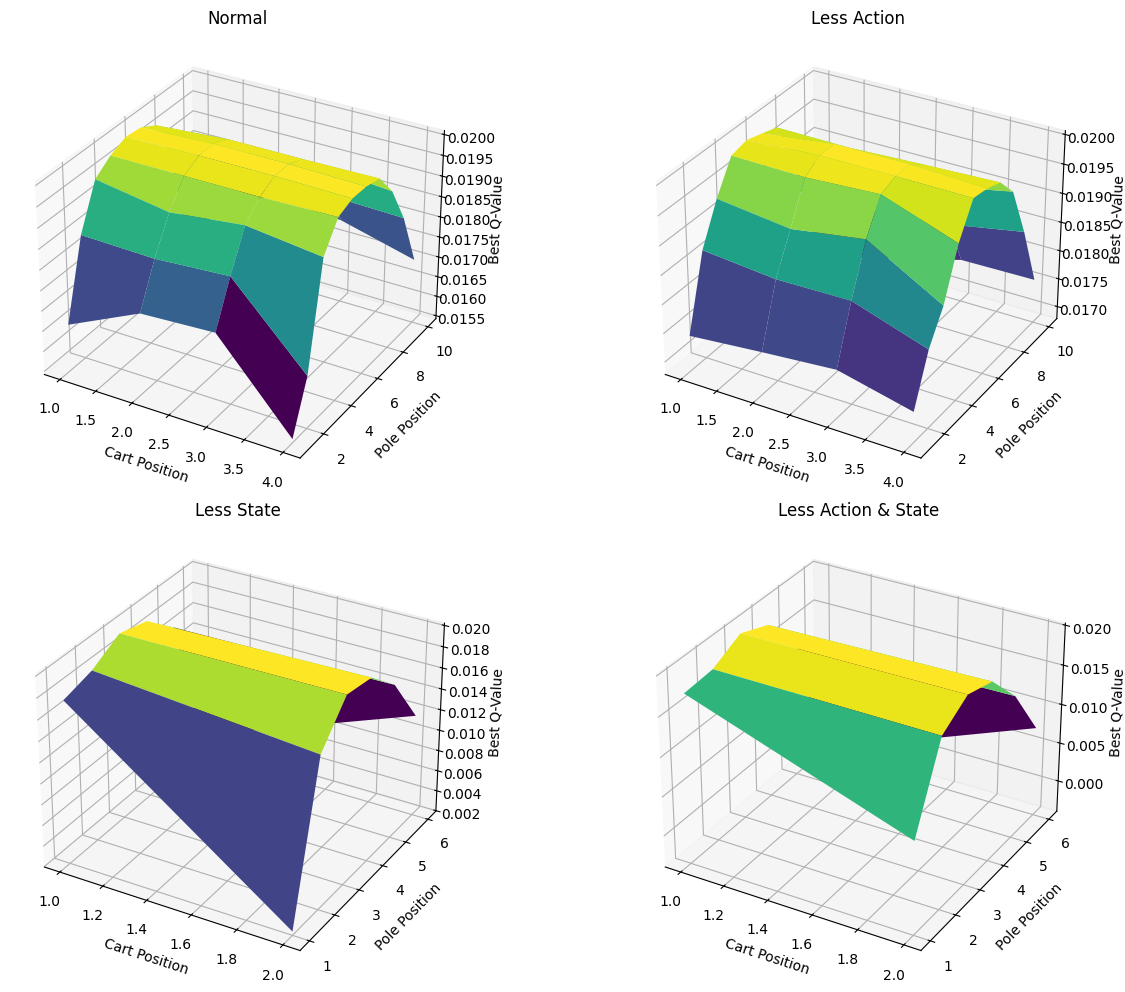

In [8]:
file_paths = [
    "./Q_learning/Normal/Q_Learning_4900_11_12.0_5_11.json",
    "./Q_learning/Lessaction/Q_Learning_4900_5_12.0_5_11.json",
    "./Q_learning/Lessstate/Q_Learning_4900_11_12.0_3_7.json",
    "./Q_learning/Lessactionandstate/Q_Learning_4900_5_12.0_3_7.json"
]

titles = ["Normal", "Less Action", "Less State", "Less Action & State"]
plot_q_values(file_paths, titles)

# base_paths = [
#     "./Q_learning/Normal/Q_Learning_4900_11_12.0_5_11.json",
#     "./Q_learning/Lessaction/Q_Learning_4900_5_12.0_5_11.json",
#     "./Q_learning/Lessstate/Q_Learning_4900_11_12.0_3_7.json",
#     "./Q_learning/Lessactionandstate/Q_Learning_4900_5_12.0_3_7.json"
# ]

# methods = ["Q_learning", "Double_Q_learning", "MC", "SARSA"]

# file_paths = []
# titles = []

# for method in methods:
#     for base in base_paths:
#         file_paths.append(base.replace("Q_learning", method))
#         titles.append(method + " - " + base.split("/")[-1].split("_")[1])

# plot_q_values(file_paths, titles)

### Why does it perform better than the others?

### How do the resolutions of the action space and observation space affect the learning process? Why?